# 準備
## 準備１  chainer のインストール

このプログラムを実行するには以下の科学系ライブラリが必要です。

- numpy
- PIL
- pandas
- matplotlib
- pickle
- sklearn
- jupyter notebook 
- chainer

chainer 以外は Anaconda に標準で入っています。これを見ている時点で jupyter は動いているわけですし、おそらく他のライブラリは導入済みのはずですので、 chainer だけ追加で導入すれば OK です。

### chainer のインストール

Windowsの場合は、スタートメニューから **Anaconda Prompt** を起動して下さい。おそらくcommand prompt でも大丈夫です。Mac や Linux の場合はターミナルです。

> ` pip install chainer `

を実行するだけで、chainer のインストールが進むはずです。インストールが始まらないとしたら python の環境ができていないということです。

自分のパソコンで実行したい人は Anaconda を導入しましょう。簡単に導入できます。ググって下さい。


## 準備２  ◯CIFAR-100画像データベースのダウンロード

- [The CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

上記リンクをたどり、[CIFAR-100 python version](https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz) をダウンロードしてこのプログラムと同じフォルダに解凍してください。

- train 訓練用データ 50000画像
- test  テスト用データ 10000画像

が入っています。28x28 ピクセルの小さなカラー画像です。

以下、次のブロックから順に　**SHIFT+ENTER** で　python プログラムを実行していってください。



In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

trainDB = unpickle("train")
testDB = unpickle("test")

In [2]:
# (カラー, たて、よこ)　形式のデータを PIL 画像に変換
def blob2img(blob):
    return Image.fromarray(np.dstack(blob))

# 　3072次元ベクトルを(3,32,32)構造にリシェイプ
def flat2image(flat):
    return blob2img(flat.reshape((3,32,32)))

# データ・セットの i 番目のデータを取り出して画像化
def getimage(data,i):
    return blob2img(data[b'data'][i].reshape((3,32,32)))

# データ・セットの start 番目から最大100画像分を表示
def showimage(data, start=0):
    canvas = Image.new('RGB',(350,350),(255,255,255))
    dsize = len(data[list(data.keys())[0]])
    end = start + 100
    if start + 100 > dsize:
        end = dsize
    for i in range(10):
        for j in range(10):
            n = start+i*10+j
            if n >= end:
                break
            else:
                canvas.paste(getimage(data,start+i*10+j),(35*j,35*i))
    return canvas

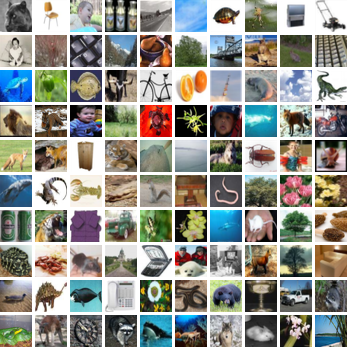

In [3]:
showimage(testDB,3567) # テスト画像の324番目から100枚表示

CIFAR-100 画像データベースの画像は0〜9の大分類番号と0~99の詳細分類番号がつけられています。カテゴリ番号と日本語の意味の対応表を用意しました。　⇒ **taxonomy.txt**

全カテゴリの表を一番下につけてあります。

In [4]:
#  カテゴリ表の表示
taxonomy = pd.read_csv("taxonomy.txt", header=0)
taxonomy = taxonomy.drop('id',axis=1)
taxonomy.head(10)  # 上から８つ


,ccat,fcat,cword,fword
0,0,4,水生哺乳類,ビーバー
1,0,30,水生哺乳類,イルカ
2,0,55,水生哺乳類,カワウソ
3,0,72,水生哺乳類,アザラシ
4,0,95,水生哺乳類,クジラ
5,1,1,魚,観賞魚
6,1,32,魚,ヒラメ
7,1,67,魚,エイ
8,1,73,魚,サメ
9,1,91,魚,マス


In [5]:
# 名称からid を調べる
def word2fcat(word):
    return taxonomy[taxonomy['fword']==word]['fcat'].iloc[0]

In [6]:
word2fcat('芝刈り機')

41

In [7]:
def getCat(data,cat):
    flabels = data[b'fine_labels']
    images = data[b'data']
    extract = []
    id = word2fcat(cat)
    for fl, img in zip(flabels,images):
        if fl == id :
            extract.append(img)  
    return extract

In [8]:
def showBimages(blobs, start=0, npic=100):  # start番目からnpic枚表示
    dsize = len(blobs)
    limit = start + npic
    if limit > dsize:
        limit = dsize
        npic = limit - start
    rows  =  (npic-1)//10+1
    print(npic,"枚")
    canvas =  Image.new('RGB',(350,35*rows),(255,255,255))
    n = start
    i = 0
    j = 0
    while n < limit:
        canvas.paste(flat2image(blobs[start+i*10+j]),(35*j,35*i))
        j +=1
        if j == 10:
            i, j = i+1,0
        n +=1
    return canvas

# showBimages(getCat(test,'カワウソ'))
# showBimages(getCat(test,'イルカ'))
# showBimages(getCat(test,'クジラ'))

100 枚


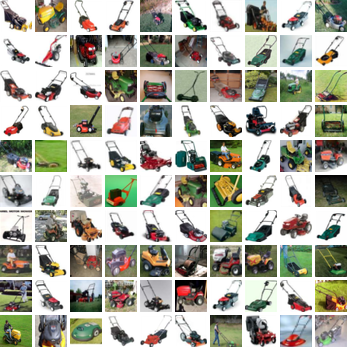

In [9]:
ｓhowBimages(getCat(testDB,'芝刈り機'))

# ３カテゴリー識別問題◯

チューリップ100枚，ヒマワリ100枚,バラ100枚を選び，計300枚を比を保ったまシャッフルして150枚を訓練に使い，150枚で認識率を出すことにする．

下では testデータから 150枚抜き出しているが、train からでもいい。
train にはデータが50000枚分もあるので抽出に時間がかかる。
test は１万枚なので train から抜き出すより早いが、100カテゴリ100枚ずつしか無い。

つまり、testから特定のカテゴリの画像100枚抜き出すということは全部ぬきだぬきだすことになる.

◯付きは読むだけでなく必ず実践しましょう。

# 1. 識別対象カテゴリーのデータの抽出◯

In [10]:
turip = getCat(testDB,'チューリップ')[0:100]
sunflower = getCat(testDB,'ヒマワリ')[0:100]
rose = getCat(testDB,'バラ')[0:100]

100 枚


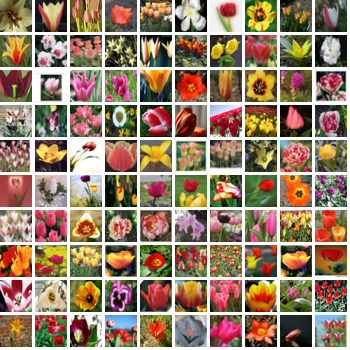

In [11]:
showBimages(turip)

100 枚


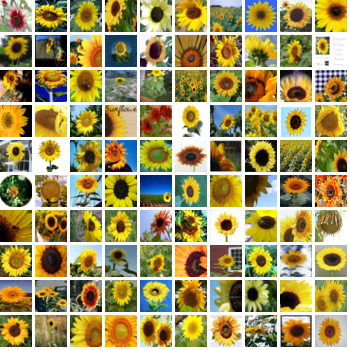

In [12]:
showBimages(sunflower)

100 枚


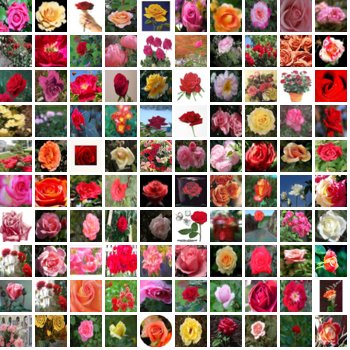

In [13]:
showBimages(rose)

# 2. 学習実験用のデータ作成◯

In [14]:
baseX = np.array(turip+sunflower+rose)
basey = np.array([0]*100+[1]*100+[2]*100).astype(np.int32) # 正解ラベル
baseX.shape

(300, 3072)

300はデータ数、3072は次元数＝32ｘ32ｘ3色

baseX が画像の配列  個々の画像は全データを１列に並べた３０７２次元ベクトルとして表されている
basey がラベル（詳細カテゴリID)の配列

# 3. 識別実験

# 3.1 ロジスティック回帰

In [15]:
X,y  = baseX, basey
from sklearn import linear_model
from sklearn.model_selection import StratifiedShuffleSplit 
# clf = linear_model.LinearRegression()  # 線形識別機を用いる
clf = linear_model.LogisticRegression()

#　訓練用とテスト用に半々にシャッフル分割
ss = StratifiedShuffleSplit(n_splits=10, 
                  train_size=0.5, 
                  test_size=0.5)

for train_index, test_index in ss.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train) # テスト用画像の認識率
    print("{:5.4f}".format(clf.score(X_test, y_test))) # 訓練用画像の認識率
    # print(clf.score(X_train, y_train))

0.5600
0.5600
0.5867
0.5133
0.5600
0.5733
0.5933
0.5667
0.5600
0.5600


ランダムに半分を訓練に使い、残りをテストに使う、という検証方法で10回
5~6割の正答率（訓練例の方はおそらく100％）

# 3.2 線形SVM　サポートベクターマシン

In [16]:
X,y  = baseX, basey
from sklearn import svm, metrics
from sklearn.model_selection import StratifiedShuffleSplit
clf = svm.LinearSVC()

ss =  StratifiedShuffleSplit(n_splits=10, train_size=0.5, test_size=0.5) # 10分割して

for train_index, test_index in ss.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    print("{:5.4f}".format(clf.score(X_test, y_test))) # 訓練用画像の認識率
    # print(clf.score(X_train, y_train))

0.5867
0.5333
0.5733
0.5600
0.5133
0.6067
0.5600
0.5933
0.5933
0.5533


SVMも正解率は５〜６割

# 誤認識画像の確認

[1 0 1 2 0 0 0 1 0 0 2 2 0 1 0 0 1 0 1 2 2 0 0 0 0 2 0 1 0 2 0 2 0 0 0 0 0
 0 0 0 0 0 2 2 1 1 1 0 0 0 0 0 0 1 2 0 2 0 2 0 0 2 1 2 0 2 0 0 0 2 0 0 2 0
 0 0 0 2 0 0 2 0 0 2 0 0 0 0 2 0 0 0 0 2 0 0 0 0 2 2 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 0 2 2 2 2 2
 2 2 2 0 2 2 1 2 2 0 2 2 0 2 0 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2
 2 2 2 2 0 0 1 2 2 2 2 2 2 1 2 2 2 2 2 0 2 0 2 2 2 0 2 2 2 2 0 2 2 0 2 2 2
 2 0 2 2]
67 枚


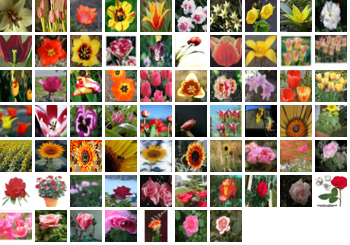

In [17]:
X,y  = baseX, basey
pred = clf.predict(X)
print(pred)
errimg = []
for i in range(300):
    if pred[i] !=y[i] :
        errimg.append(X[i])
showBimages(errimg,0)

# 3.3 CNN ◯
### 準備１　reshape ◯
ここまでは、画像データを1次元的に展開して扱ってきたが、CNN では画像を

　（チャネル, 高さ, 幅）
 
 という形式で入力データとしなければならない。そこでまず、reshape する。

### 準備２ 平均値を引く ◯
データ全体のRGBそれぞれの平均値を求めて各データから引いて平均が０になるようにする。
必然ではないが、そうした方が収束が早いらしい。

In [18]:
X, y  = baseX, basey
X_ = X.copy().reshape((300,3,32,32)).astype(np.float32)
mean = np.average(np.average(np.average(X_,axis=0),axis=1),axis=1) # RGB それぞれの平均
print("RGB平均値",mean)
X_[:,0,:,:]=X_[:,0,:,:]-mean[0]
X_[:,1,:,:]=X_[:,1,:,:]-mean[1]
X_[:,2,:,:]=X_[:,2,:,:]-mean[2] 
X_ = X_/127.0  # -1〜+1 で表現
y = y.astype(np.int32)
Pdata = [(x,label) for x,label in zip(X_,y)] # データとラベルのペアデータ
baseX_ = X_ # 分離データ

RGB平均値 [ 137.78987122  110.60895538   78.10410309]


## 準備３ ディープラーニング用のライブラリのインポート◯

In [19]:
import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
from chainer import training
from chainer.datasets import tuple_dataset
from chainer.iterators import SerialIterator
from chainer import training
from chainer.training import trainer, extensions
from chainer.dataset import concat_examples

## 3.3.1 典型的なCNN◯

1. ３ｘ３畳み込み　32チャネル 　  -> 32x32x32チャネル
2. max pooling 2x2 -> 16x16x32チャネル
3. ３ｘ３畳み込み　32チャネル　 -> 16x16x32チャネル
4.  max pooling 2x2 -> 8x8x32チャネル
5.　1024ノード全結合  -> 1024ノード
6. 128ノード全結合  -> 128ノード
7. 3ノード全結合 -> 3ノード
8.　Softmax 出力

畳み込み層と全結合層の活性化関数としては ReLU関数を用いる

In [20]:
class MyNet(chainer.Chain):
    def __init__(self):
        super(MyNet,self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(3,32,3,1,1)
            self.conv2 = L.Convolution2D(32,32,3,1,1)
            self.l1 = L.Linear(2048,1024)
            self.l2 = L.Linear(1024,3)

    def __call__(self,x):
        h = Variable(x)
        h = F.relu(self.conv1(h))
        h = F.max_pooling_2d(h,2,2)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h,2,2)
        h = F.dropout(F.relu(self.l1(h)))
        if chainer.config.train:
            return self.l2(h)
        return F.softmax(self.l2(h))
    
model = MyNet()
# model = L.Classifier(model)

# 訓練例を準備◯

In [21]:
# データをシャッフルして半分をて訓練用、半分をテスト用に分ける
from sklearn import svm, metrics
from sklearn.model_selection import StratifiedShuffleSplit
ss =  StratifiedShuffleSplit(n_splits=1, train_size=0.5, test_size=0.5) 
for g1, g2 in ss.split(Pdata, basey):
    train = [Pdata[x] for x in g1]
    test = [Pdata[x] for x in g2]

# 訓練ループの定義◯

In [22]:
def trainloop(model, max_epoch=10, batchsize =10,traintimes = 0):
    # batchsize = 10  # バッチサイズ　　データセットをこのサイズに分割し、少しずつ学習する
    # max_epoch = 10 #  全訓練データを何回学習するか

    train_iter = SerialIterator(train, batch_size=batchsize, shuffle=True)
    test_iter = SerialIterator(test, batch_size=batchsize,repeat=False, shuffle=False)

    # chainer には典型的な設定で繰り返しトレーニングする trainer という仕組みが用意されている
    # updater = training.StandardUpdater(train_iter, optimizer)
    # trainer = training.Trainer(updater, (2, 'epoch'), out='result')
    # 今回は使わないで自分で定義することにする。

    print('epoc   train_loss      train_accuracy      test_loss      test_accuracy')

    
    train_losses = []
    train_accuracies = []
    
    while train_iter.epoch < max_epoch:

        #  --  ここから訓練のフェーズ
        train_batch = train_iter.next()  # バッチ単位で例を取り出す
        X, y = concat_examples(train_batch)  # データとラベルに分離
    
        pred = model(X)  # 現時点での出力を求める
        loss = F.softmax_cross_entropy(pred, y)  # 現出力と理想出力の交差エントロピーを計算
        
        train_losses.append(float(loss.data))
        train_accuracies.append(float(F.accuracy(pred, y).data))
    
        model.cleargrads() # 微係数データを初期化
        loss.backward() # 誤差を逆伝搬する。
    
        optimizer.update()  # 　誤差が減るように重みを更新
        #  --  訓練のフェーズここまで
    
        if train_iter.is_new_epoch:   # max_epoch ごとに評価
            traintimes += 1
        
               
            test_losses = []
            test_accuracies = []
            while True:
                test_batch = test_iter.next() # テストデータからバッチ単位分取り出す
                X, y = concat_examples(test_batch)  #データとラベルに分離

                pred = model(X) # 出力を求める
                loss = F.softmax_cross_entropy(pred, y) # 交差エントロピーを計算
                test_losses.append(float(loss.data))

                # 認識率を計算する
                accuracy = F.accuracy(pred, y)
                test_accuracies.append(float(accuracy.data))

                if test_iter.is_new_epoch:
                    test_iter.epoch = 0
                    test_iter.current_position = 0
                    test_iter.is_new_epoch = False
                    test_iter._pushed_position = None
                    break
                        
            print(' {:03d}      {:.04f}           {:.04f}'.format(
                  train_iter.epoch, np.mean(train_losses), np.mean(train_accuracies)),end="")
            train_loss,  train_accuracies= [], []    
            print('                 {:.04f}          {:.04f}'.format(
                 np.mean(test_losses), np.mean(test_accuracies)))

# オプティマイザーを作成し、訓練実行◯

In [23]:
model = MyNet() # オプティマイザーを変えるなら model を再定義すべき

optimizer = optimizers.Adam()
# optimizer = optimizers.AdaGrad()
# optimizer = optimizers.SGD()
optimizer.setup(model)

trainloop(model = model, max_epoch=10, batchsize =10,traintimes = 0)

epoc   train_loss      train_accuracy      test_loss      test_accuracy
 001      1.2327           0.5200                 0.9095          0.5133
 002      0.9569           0.7333                 0.7696          0.6267
 003      0.8219           0.7533                 0.9961          0.5267
 004      0.7275           0.8067                 0.9326          0.6133
 005      0.6630           0.8600                 0.8514          0.6533
 006      0.5993           0.9067                 0.8173          0.6600
 007      0.5428           0.9333                 1.2305          0.5933
 008      0.4950           0.9467                 1.1149          0.6267
 009      0.4543           0.9733                 1.1727          0.6267
 010      0.4152           0.9933                 1.0994          0.6267


訓練データの accuracy （正答率）がほぼ１になるのは当然で、大事なのはtest データの方の正答率（testacc)です。選ばれたデータと乱数次第で、だいたい６〜７割の正答率が出ます

# ☆誤り事例を表示

[1 2 1 2 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 2 0 0 0 2 0 0 2 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 1 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 2 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 0 2 2 2
 2 2 2 2 2 0 1 2 0 2 0 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 0 0 1 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2]
52 枚


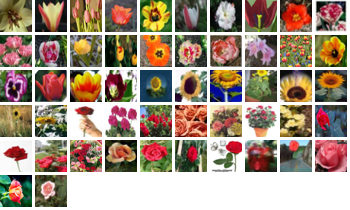

In [24]:
predall  = np.argmax(model(baseX_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(baseX[i])
showBimages(errimg,0)

# 3.3.2 ３層バックプロパゲーションネット

In [25]:
class MyNet2(chainer.Chain):
    def __init__(self):
        super(MyNet2,self).__init__()
        with self.init_scope():
            # self.conv1 = L.Convolution2D(3,32,3,1,1)
            self.l1 = L.Linear(3072,32)
            self.l2 = L.Linear(32,16)
            self.l3 = L.Linear(16,3)

    def __call__(self,x):
        h = Variable(x)
        # h = F.relu(self.conv1(h))
        # h = F.max_pooling_2d(h,2,2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        if chainer.config.train:
            return self.l3(h)
        return F.softmax(self.l3(h))

In [26]:
model2 = MyNet2()

optimizer = optimizers.Adam()
optimizer.setup(model2)

trainloop(model = model2, max_epoch=10, batchsize =10,traintimes = 0)

epoc   train_loss      train_accuracy      test_loss      test_accuracy
 001      1.0743           0.3400                 0.9386          0.4933
 002      0.9072           0.6800                 0.8700          0.6133
 003      0.7677           0.8733                 0.8800          0.6333
 004      0.6577           0.9067                 0.8838          0.6533
 005      0.5701           0.9667                 0.9532          0.6333
 006      0.4992           0.9733                 0.9562          0.6333
 007      0.4436           0.9933                 1.0269          0.6467
 008      0.3963           1.0000                 1.0652          0.6400
 009      0.3576           1.0000                 1.1193          0.6533
 010      0.3251           1.0000                 1.1562          0.6467


ノード数が中間層１６と少なく設定してあるので、学習は短時間で済みます。
６割前半〜運が良ければ７割弱程度の正答率が出ます。

[1 2 0 2 0 2 2 1 2 2 0 0 0 0 2 0 2 0 0 2 0 0 0 0 0 2 0 0 0 2 0 2 2 0 0 0 2
 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 2 2 2 0 0 0 2 0 0 0 0
 0 0 0 2 0 0 2 0 1 2 2 0 0 1 2 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 0 1 2 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2
 2 2 2 2 2 1 1 2 0 2 2 2 2 1 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 2]
53 枚


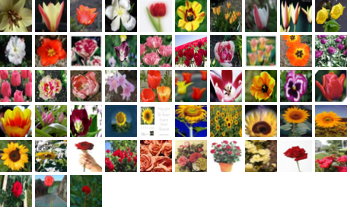

In [27]:
predall  = np.argmax(model2(baseX_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(baseX[i])
showBimages(errimg,0)

中間層がたったの16ノードの三層ニューラルネットでもあまり認識率に変わりがなかった

[Batch Normalization：ニューラルネットワークの学習を加速させる汎用的で強力な手法](https://deepage.net/deep_learning/2016/10/26/batch_normalization.html)

# 3.3.3 よりディープなCNN
畳み込み×２　⇒　プーリング　⇒　畳み込み　　⇒　プーリング　⇒　畳み込み　⇒　プーリング　⇒　全結合３層

In [28]:
class MyNet3(chainer.Chain):
    def __init__(self):
        super(MyNet3,self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(3,32,3,1,1)
            self.conv2 = L.Convolution2D(32,32,3,1,1)
            self.bnorm1 = L.BatchNormalization(32)
            self.conv3 = L.Convolution2D(32,64,3,1,1)
            self.bnorm2 = L.BatchNormalization(64)
            self.conv4 = L.Convolution2D(64,128,3,1,1)
            self.bnorm3 = L.BatchNormalization(128)
            self.l1 = L.Linear(2048,512)
            self.bnorm4 = L.BatchNormalization(512)
            self.l2 = L.Linear(512,256)
            self.bnorm5 = L.BatchNormalization(256)
            self.l3 = L.Linear(256,3)

    def __call__(self,x):
        h = Variable(x)
        h = F.relu(self.conv1(h))
        h = F.relu(self.conv2(h))
        h = F.dropout(h)
        h = F.max_pooling_2d(h,2,2)
        h = self.bnorm1(h)
        h = F.relu(self.conv3(h))
        h = F.max_pooling_2d(h,2,2)
        h = self.bnorm2(h)
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(h,2,2)
        h = self.bnorm3(h)
        h = F.dropout(F.relu(self.l1(h)))
        h = self.bnorm4(h)
        h = F.dropout(F.relu(self.l2(h)))
        h = self.bnorm5(h)
        if chainer.config.train:
            return self.l3(h)
        return F.softmax(self.l3(h))
    
model = MyNet3()
# model = L.Classifier(model)

In [29]:
model3 = MyNet3()

optimizer = optimizers.Adam(0.001)
optimizer.setup(model3)

trainloop(model = model3, max_epoch=20, batchsize =50,traintimes = 0)

epoc   train_loss      train_accuracy      test_loss      test_accuracy
 001      1.2520           0.3600                 1.0629          0.5067
 002      0.9965           0.6400                 0.8960          0.5800
 003      0.9064           0.7000                 0.9612          0.5867
 004      0.8168           0.7733                 0.9983          0.5600
 005      0.7544           0.7933                 0.8799          0.6200
 006      0.7028           0.8133                 0.9661          0.5533
 007      0.6520           0.9067                 0.9786          0.5733
 008      0.6143           0.8667                 0.9806          0.6133
 009      0.5769           0.9200                 0.9920          0.6467
 010      0.5446           0.8867                 0.8976          0.6400
 011      0.5107           0.9533                 1.1284          0.5933
 012      0.4836           0.9200                 1.0480          0.6200
 013      0.4561           0.9667                 1.

ディープなので時間がかかります。その割にはそれほどパフォーマンスが上がりません。
深くなるほどパラメータが増えるのでチューニングが非常に難しいです。

それでもこれほど深くても学習が進むようになったのは最近の研究成果の賜物なのです。

[0 2 0 2 0 2 1 1 0 2 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 2 0 0 0 2 0 2 2 0 0 0 2
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2
 2 2 2 1 2 0 1 2 0 2 2 2 0 1 2 2 2 2 0 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 2 2
 2 1 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
51 枚


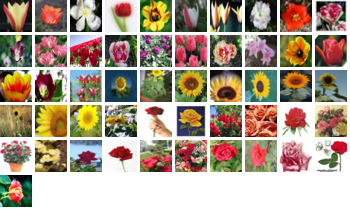

In [30]:
# 誤りデータの確認
predall  = np.argmax(model3(baseX_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(baseX[i])
showBimages(errimg,0)

ネットが深くて時間がかかる割に結果はぱっとしない

# 3.3.4 全結合層がないとどうなるか

```
1. 3x3 　畳み込み×１６
2. 7x7 畳み込み×４
3.  １と２を合わせたチャネル　
  ⇒　4x4 ストライド 2 の max pooling 
  ⇒　畳み込み 64 
  ⇒　4x4 ストライド 2 の max pooling 

全結合層なし
```

In [31]:
class MyNet4(chainer.Chain):
    def __init__(self):
        super(MyNet4,self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(3,16,3,1,1)
            self.conv2 = L.Convolution2D(3,4,7,1,3)
            self.conv3 = L.Convolution2D(20,64,1,1)
            # self.conv4 = L.Convolution2D(32,64,3,1,1)
            self.l2= L.Linear(3136,3)
            #self.l2 = L.Linear(256,3)

    def __call__(self,x):
        h = Variable(x)
        h1 = F.relu(self.conv1(h))
        h2 = F.relu(self.conv2(h))
        h = F.hstack([h1 ,h2])
        h = F.max_pooling_2d(h,4,2)
        h = F.relu(self.conv3(h))
        h = F.max_pooling_2d(h,4,2)
        # h = F.relu(self.conv4(h))
        # h = F.max_pooling_2d(h,2,2)
        # h = F.dropout(F.relu(self.l1(h)))
        if chainer.config.train:
            return self.l2(h)
        return F.softmax(self.l2(h))
    
model = MyNet4()
# model = L.Classifier(model)

In [32]:
model4 = MyNet4()

optimizer = optimizers.Adam(0.001)  # 学習係数 0.001 がデフォルト
optimizer.setup(model4)

trainloop(model = model4,max_epoch=20, batchsize =50,traintimes = 0)

epoc   train_loss      train_accuracy      test_loss      test_accuracy
 001      1.2110           0.3267                 1.0768          0.4133
 002      1.0747           0.5600                 1.1179          0.4733
 003      1.0401           0.5533                 0.9108          0.5667
 004      0.9751           0.6467                 0.9382          0.5733
 005      0.9303           0.6600                 0.8028          0.5600
 006      0.8807           0.7667                 0.8020          0.6267
 007      0.8411           0.7200                 0.7542          0.6067
 008      0.8073           0.7533                 0.7555          0.6600
 009      0.7778           0.7667                 0.7151          0.6133
 010      0.7495           0.8333                 0.7242          0.6133
 011      0.7253           0.8467                 0.7036          0.6400
 012      0.7025           0.8667                 0.6951          0.6333
 013      0.6815           0.8800                 0.

意外なことに、わりと安定したパフォーマンスが得られます。良い学習セットに当たれば７０％を超えます。

[1 2 0 2 0 2 2 1 0 2 0 0 0 0 2 0 1 0 0 2 0 0 0 0 0 2 2 1 2 2 0 2 2 0 2 0 2
 0 2 2 2 0 0 2 0 0 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 2 0 2 2 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 1 2 2 0 0 1 0 0 0 0 0 0 0 0 2 0 2 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2 0 2 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 0 2 2 2
 2 0 2 2 2 0 1 2 0 2 2 2 0 0 2 0 2 2 0 2 2 2 0 2 2 2 0 0 2 2 2 2 2 2 0 2 2
 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2
 2 2 2 2]
64 枚


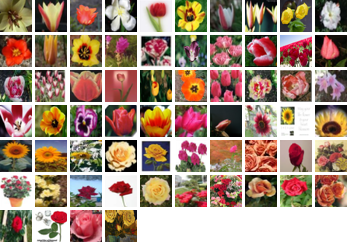

In [33]:
predall  = np.argmax(model4(baseX_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(baseX[i])
showBimages(errimg,0)

??? 正解率が高かったのに正解率が低かった場合より誤り画像の数が多くて、「あれっ？」と思うことがありますが、それは正解率はテスト画像セットに対する値で、ここで表示している誤り画像は訓練画像とテスト画像を合わせた場合の誤りだからです。

テスト画像に対する正答率は高いが、訓練画像で誤ってしまうという場合があるわけです。

# ４．別のデータセットでの検証

最後に、train （訓練用）50000枚中のチューリップ、ヒマワリ、バラの画像 各 500枚合計1500枚で認識率を出してみよう。

In [34]:
turip2 = getCat(trainDB,'チューリップ')
sunflower2 = getCat(trainDB,'ヒマワリ')
rose2 = getCat(trainDB,'バラ')
X2 = np.array(turip2+sunflower2+rose2)
y2 = np.array([0]*500+[1]*500+[2]*500).astype(np.int32) # 正解ラベル
X2_ = X2.copy().reshape((1500,3,32,32)).astype(np.float32)
X2_[:,0,:,:]=X2_[:,0,:,:]-mean[0]
X2_[:,1,:,:]=X2_[:,1,:,:]-mean[1]
X2_[:,2,:,:]=X2_[:,2,:,:]-mean[2]   # mean は学習用のものを使う
X2_ = X2_/127.0  # -1〜+1 で表現

predall2  = np.argmax(model4(X2_).data,axis=1)

In [35]:
s1,s2,s3 = 0,0,0

for i in range(500):
    if predall2[i] != 0:
        s1 += 1
    if predall2[500+i] != 1:
        s2 += 1
    if predall2[1000+i] != 2:
        s3 += 1

print("チューリップの誤認識は {} 枚 正解率 {}%".format(s1, np.round((500-s1)/5,2)))
print("ヒマワリの誤認識は {} 枚 正解率 {}%".format(s2, np.round((500-s2)/5,2)))
print("バラの誤認識は {} 枚 正解率 {}%".format(s3, np.round((500-s3)/5,2)))

es = s1+s2+s3
cs = 1500 - es
print("全枚数 {} 枚中、正解 {} 枚、不正解{}枚、正解率{}%".format(1500, cs,es,np.round(cs/15,2)) )
'''errimg2 = []
for i in range(1500):
    if predall2[i] !=y2[i] :
        errimg2.append(X2[i])
showBimages(errimg2,0,len(errimg2))''';

チューリップの誤認識は 286 枚 正解率 42.8%
ヒマワリの誤認識は 78 枚 正解率 84.4%
バラの誤認識は 180 枚 正解率 64.0%
全枚数 1500 枚中、正解 956 枚、不正解544枚、正解率63.73%


学習した枚数が150枚でテストデータ150枚での正答率は全体の正答率とほぼ同じでした。
画像に統計的な偏りがなかったということと、それを前提として150枚のサンプル調査で全体のパフォーマンスがだいたい予想できているということを意味します。

今回はたったの3カテゴリなのにこんなに低い正解率でしたが、CIFAR-100の識別問題は結構難しく、下記の [What is the class of this image ?](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)によれば、世界最高で75％程度の認識率です。もっともそれは100カテゴリでの数字ですが。


# 参考文献など

実装に関して参考にしたサイト
- [chainer tutorial](https://docs.chainer.org/en/latest/tutorial/train_loop.html)
- [CIFAR-10, CIFAR-100のデータを読み込む方法](http://qiita.com/supersaiakujin/items/5e9d2b2850e256f99982)

CNNの分かりやすい解説
- [定番のConvolutional Neural Networkをゼロから理解する](https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html)
- [Optimizer についての解説](http://qiita.com/tokkuman/items/1944c00415d129ca0ee9)

chainer には CIFAR-10, CIFAR-100のデータを読み込むためのメソッドが用意されているのでそれを使えば一発なのですが、今回はそれを使っていません。

さまざまな認識課題とそのチャレンジ状況をまとめてくれているサイト

- [What is the class of this image ?](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

- [カテゴリー別アーカイブ: CIFAR-100](http://tensorflow.classcat.com/category/cifar-100/)
-- [TensorFlow の各種ドキュメントの翻訳 | TensorFlow の簡単な応用例](http://tensorflow.classcat.com/)

# 付録

# CIFER-100　のカテゴリ分類
|||
|:--|:--|
|スーパークラス|クラス|
|海洋哺乳類|ビーバー, イルカ, カワウソ, アザラシ, クジラ|
|魚類|観賞魚, ヒラメ, エイ, サメ, マス|
|花|ラン, ポピー, バラ, ヒマワリ, チューリップ|
|食品|ボトル, ボウル, カン, カップ, プレート|
|果物と野菜|リンゴ, キノコ, オレンジ, ナシ, ピーマン|
|家電|時計, キーボード, ランプ, 電話, テレビ|
|家具|ベッド, 椅子, ソファー, テーブル, タンス|
|昆虫|蜂, 甲虫, 蝶, いも虫, ゴキブリ|
|大型肉食獣|クマ, ヒョウ, ライオン, トラ,オオカミ|
|屋外の大型建造物|橋, 城, 家, 道, 超高層ビル|
|自然シーン|雲, 森, 山, 平原, 海|
|草食または雑食の動物|ラクダ, ウシ, チンパンジー, ゾウ, カンガルー|
|中型哺乳類|キツネ, ヤマアラシ, フクロネズミ, アライグマ, スカンク|
|無脊椎動物（昆虫は除く）|カニ, ロブスター, カタツムリ, クモ, ミミズ|
|人|赤ちゃん, 男の子, 女の子, 男性, 女性|
|爬虫類|ワニ, 恐竜, トカゲ, ヘビ, カメ|
|小型哺乳類|ハムスター, マウス, ウサギ, トガリネズミ, リス|
|木|カエデ, カシ, ヤシ, マツ,ヤナギ|
|乗り物 1|自転車, バス, オートバイ, ピックアップトラック, 電車|
|乗り物 2|芝刈り機, ロケット, 路面電車, タンク, トラクタ|
 

### taxonomy.txt

以下が、プログラム中で読み込んでいるカテゴリ表（taxonomy.txt）の内容です。メモ帳等にコピペして taxonomy.txt というファイル名でこのプログラムと同じフォルダに保存して下さい。

---

```
id,ccat,fcat,cword,fword
0,0,4,水生哺乳類,ビーバー
1,0,30,水生哺乳類,イルカ
2,0,55,水生哺乳類,カワウソ
3,0,72,水生哺乳類,アザラシ
4,0,95,水生哺乳類,クジラ
5,1,1,魚,観賞魚
6,1,32,魚,ヒラメ
7,1,67,魚,エイ
8,1,73,魚,サメ
9,1,91,魚,マス
10,2,54,花,ラン
11,2,62,花,ポピー
12,2,70,花,バラ
13,2,82,花,ヒマワリ
14,2,92,花,チューリップ
15,3,9,食器,ボトル
16,3,10,食器,ボウル
17,3,16,食器,缶
18,3,28,食器,カップ
19,3,61,食器,プレート
20,4,0,果物と野菜,リンゴ
21,4,51,果物と野菜,キノコ
22,4,53,果物と野菜,オレンジ
23,4,57,果物と野菜,ナシ
24,4,83,果物と野菜,ピーマン
25,5,22,家電,時計
26,5,39,家電,キーボード
27,5,40,家電,ランプ
28,5,86,家電,電話
29,5,87,家電,テレビ
30,6,5,家具,ベッド
31,6,20,家具,椅子
32,6,25,家具,ソファー
33,6,84,家具,テーブル
34,6,94,家具,タンス
35,7,6,昆虫,蜂
36,7,7,昆虫,甲虫
37,7,14,昆虫,蝶
38,7,18,昆虫,いも虫
39,7,24,昆虫,ゴキブリ
40,8,3,大型肉食獣,クマ
41,8,42,大型肉食獣,ヒョウ
42,8,43,大型肉食獣,ライオン
43,8,88,大型肉食獣,トラ
44,8,97,大型肉食獣,オオカミ
45,9,12,屋外の大型建造物,橋
46,9,17,屋外の大型建造物,城
47,9,37,屋外の大型建造物,家
48,9,68,屋外の大型建造物,道路
49,9,76,屋外の大型建造物,超高層ビル
50,10,23,自然シーン,雲
51,10,33,自然シーン,森林
52,10,49,自然シーン,山
53,10,60,自然シーン,平原
54,10,71,自然シーン,海
55,11,15,草食または雑食の動物,ヒツジ
56,11,19,草食または雑食の動物,ウシ
57,11,21,草食または雑食の動物,チンパンジー
58,11,31,草食または雑食の動物,ゾウ
59,11,38,草食または雑食の動物,カンガルー
60,12,34,中型哺乳類,キツネ
61,12,63,中型哺乳類,ヤマアラシ
62,12,64,中型哺乳類,フクロネズミ
63,12,66,中型哺乳類,ラクーン
64,12,75,中型哺乳類,スカンク
65,13,26,無脊椎動物（昆虫は除く）,カニ
66,13,45,無脊椎動物（昆虫は除く）,ロブスター
67,13,77,無脊椎動物（昆虫は除く）,カタツムリ
68,13,79,無脊椎動物（昆虫は除く）,クモ
69,13,99,無脊椎動物（昆虫は除く）,ミミズ
70,14,2,人,赤ちゃん
71,14,11,人,男の子
72,14,35,人,女の子
73,14,46,人,男性
74,14,98,人,女性
75,15,27,爬虫類,クロコダイル
76,15,29,爬虫類,恐竜
77,15,44,爬虫類,トカゲ
78,15,78,爬虫類,ヘビ
79,15,93,爬虫類,カメ
80,16,36,小型哺乳類,ハムスター
81,16,50,小型哺乳類,マウス
82,16,65,小型哺乳類,ウサギ
83,16,74,小型哺乳類,トガリネズミ
84,16,80,小型哺乳類,リス
85,17,47,木,カエデ
86,17,52,木,カシ
87,17,56,木,ヤシ
88,17,59,木,マツ
89,17,96,木,ヤナギ
90,18,8,乗り物1,自転車
91,18,13,乗り物1,バス
92,18,48,乗り物1,オートバイ
93,18,58,乗り物1,ピックアップトラック
94,18,90,乗り物1,列車
95,19,41,乗り物2,芝刈り機
96,19,69,乗り物2,ロケット
97,19,81,乗り物2,路面電車
98,19,85,乗り物2,タンク
99,19,89,乗り物2,トラクター
```
---


# 課題
1. まず、ここまでのプログラムを上から順に実行し少なくとも、「☆」付きの「☆誤り事例を表示」までは SHIFT+ENTER で実行して下さい。
2. 内容を理解して、下のプログラムの「ヒマワリ」「チューリップ」「バラ」の部分を別のカテゴリに置き換えて、以下を実行し、結果をレポートにまとめて報告する。

## 考察すべき事項
1. 分類対象カテゴリ　　　認識精度の高い組わせと低い組合せ、なぜそうなのか
2. 識別モデル  myNet, myNet2, myNet3, myNet4 、その他
3. どのオプティマイザーがよいか

表、グラフ、図を貼っただけのものはレポートではありません。
課題内容や手順、考察をきちんとした文章を記載すること。

また、理解できない言葉や概念は調べること。

In [39]:
catname1,catname2,catname3 = '赤ちゃん','山','バス' # ←できて当然であまりよろしくない例

cat1 = getCat(testDB,catname1) # catname1 の画像データを抽出
cat2 = getCat(testDB,catname2) # catname２ の画像データを抽出
cat3 = getCat(testDB,catname3) # catname３ の画像データを抽出

X3 = np.array(cat1+cat2+cat3)
y3 = np.array([0]*100+[1]*100+[2]*100).astype(np.int32) # 正解ラベル

X3_ = X3.copy().reshape((300,3,32,32)).astype(np.float32) # ４次元データ化
mean3 = np.average(np.average(np.average(X3_,axis=0),axis=1),axis=1) # RGB それぞれの平均
print("RGB平均値",mean3)

X3_[:,0,:,:]=X3_[:,0,:,:]-mean3[0] # 各データから RGB の平均値を引く。
X3_[:,1,:,:]=X3_[:,1,:,:]-mean3[1]
X3_[:,2,:,:]=X3_[:,2,:,:]-mean3[2]   
X3_ = X3_/127.0  # -1〜+1 の表現に変換

Pdata3 = [(x,label) for x,label in zip(X3_,y3)] # データとラベルのペアデータ

RGB平均値 [ 126.69330597  122.54710388  122.38278198]


In [40]:
# データをシャッフルして半分をて訓練用、半分をテスト用に分ける
from sklearn import svm, metrics
from sklearn.model_selection import StratifiedShuffleSplit
ss =  StratifiedShuffleSplit(n_splits=5, train_size=0.5, test_size=0.5) 
for g1, g2 in ss.split(Pdata3, y3):
    train = [Pdata3[x] for x in g1]
    test = [Pdata3[x] for x in g2]

In [41]:
model = MyNet() # <= 認識ネットワークを変えるならここを書き換える

# 一番最初の CNN のモデルで　２５エポック（エポックとは全学習データを一通り１度学習すること）
# 学習は １度に50 画像分ずつ学習。

optimizer = optimizers.Adam(alpha=0.0005, beta1=0.9, beta2=0.999, eps=1e-08)  # 学
# optimizer = optimizers.SGD(lr=0.01)
# optimizer = optimizers.MomentumSGD(lr=0.01, momentum=0.9)
# optimizer = optimizers.RMSpropGraves(lr=0.0001, alpha=0.95, momentum=0.9, eps=0.0001)
# optimizer = optimizers.AdaDelta(rho=0.95, eps=1e-06)
optimizer.setup(model)
trainloop(model = model, max_epoch=20, batchsize =10,traintimes = 0)

epoc   train_loss      train_accuracy      test_loss      test_accuracy
 001      1.1210           0.5533                 0.8101          0.6067
 002      0.8663           0.7400                 0.8253          0.7133
 003      0.7384           0.7933                 0.6445          0.7133
 004      0.6337           0.8600                 0.6839          0.7533
 005      0.5663           0.9067                 0.6500          0.7467
 006      0.5094           0.9400                 0.7242          0.7600
 007      0.4651           0.9267                 0.6119          0.8067
 008      0.4205           0.9667                 0.6372          0.7933
 009      0.3810           0.9933                 0.8208          0.7533
 010      0.3476           1.0000                 0.8764          0.7400
 011      0.3193           0.9933                 0.6815          0.8067
 012      0.2961           0.9933                 1.0691          0.7267
 013      0.2752           1.0000                 0.

### 上に表示されている結果を見出しの行から一番下までマウスで選んで「コピー」し、次のブロックを実行してみて下さい。

In [42]:
import pandas as pd
df = pd.read_clipboard()
df

,epoc,train_loss,train_accuracy,test_loss,test_accuracy
0,1,1.1210,0.5533,0.8101,0.6067
1,2,0.8663,0.7400,0.8253,0.7133
2,3,0.7384,0.7933,0.6445,0.7133
3,4,0.6337,0.8600,0.6839,0.7533
4,5,0.5663,0.9067,0.6500,0.7467
5,6,0.5094,0.9400,0.7242,0.7600
6,7,0.4651,0.9267,0.6119,0.8067
7,8,0.4205,0.9667,0.6372,0.7933
8,9,0.3810,0.9933,0.8208,0.7533
9,10,0.3476,1.0000,0.8764,0.7400


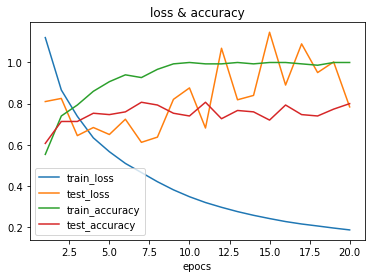

In [43]:
if df.size >50:
    plt.plot(df['epoc'],df['train_loss'])
    plt.plot(df['epoc'],df['test_loss'])
    plt.plot(df['epoc'],df['train_accuracy'])
    plt.plot(df['epoc'],df['test_accuracy'])
    plt.title("loss & accuracy")
    plt.xlabel("epocs")
    plt.legend() 

最後にご認識された画像を確認しておきましょう。

[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 0 2 2 2 2 2 2 2 2 2 0 1 2 2 2 1 2 2 1
 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2
 2 2 1 2 2 2 2 2 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 1 1 1
 2 2 2 2]
赤ちゃんの誤認識は 9 枚 正解率 91%
山の誤認識は 6 枚 正解率 94%
バスの誤認識は 19 枚 正解率 81%
全枚数 300 枚中、正解 266 枚、不正解34枚、正解率88.67%
34 枚


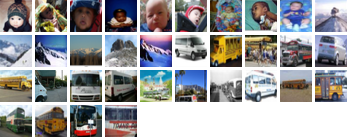

In [44]:
predall  = np.argmax(model(X３_).data,axis=1)
print(predall)
errimg = []
for i in range(300):
    if predall[i] !=basey[i] :
        errimg.append(X3[i])

s1,s2,s3 = 0,0,0
for i in range(100):
    if predall[i] != 0:
        s1 += 1
    if predall[100+i] != 1:
        s2 += 1
    if predall[200+i] != 2:
        s3 += 1

print("{}の誤認識は {} 枚 正解率 {}%".format(catname1,s1, 100-s1))
print("{}の誤認識は {} 枚 正解率 {}%".format(catname2,s2, 100-s2))
print("{}の誤認識は {} 枚 正解率 {}%".format(catname3,s3, 100-s3))
es = s1+s2+s3
cs = 300 - es
print("全枚数 {} 枚中、正解 {} 枚、不正解{}枚、正解率{}%".format(300, cs,es,np.round(cs/3,2)) )
showBimages(errimg,0)


# お疲れ様でした

In [ ]:
!python
